In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import shapiro, ttest_ind

%matplotlib inline  
pd.options.display.max_columns = None

In [2]:
def convert_and_check(data, column, min_=None, max_=None, nan_val=np.NaN, fill_nan_val=None):
    data[column] = pd.to_numeric(data[column], errors='coerce', downcast='float')
    data[column] = data[column].astype('float64')
    if min_ is not None:
        data.loc[data[column] < min_, column] = nan_val
    if max_ is not None:
        data.loc[data[column] > max_, column] = nan_val
    if fill_nan_val is not None:
        data[column] = data[column].fillna(fill_nan_val)

### Чтение данных

In [3]:
rating = pd.read_csv('IMDB/title.ratings.tsv', sep='\t')

In [4]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941363 entries, 0 to 941362
Data columns (total 3 columns):
tconst           941363 non-null object
averageRating    941363 non-null float64
numVotes         941363 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 21.5+ MB


In [5]:
rating.describe()

,averageRating,numVotes
count,941363.000000,9.413630e+05
mean,6.909567,9.688633e+02
std,1.399651,1.562005e+04
min,1.000000,5.000000e+00
25%,6.200000,9.000000e+00
50%,7.100000,2.000000e+01
75%,7.900000,7.700000e+01
max,10.000000,2.100257e+06


In [6]:
title = pd.read_csv('IMDB/title.basics.tsv', sep='\t', dtype=str, quoting=csv.QUOTE_NONE, na_values='\\N')
for col in title.columns:
    title[col] = title[col].astype('str')
title.replace("nan", "", inplace=True)

In [7]:
title.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5922266 entries, 0 to 5922265
Data columns (total 9 columns):
tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult           object
startYear         object
endYear           object
runtimeMinutes    object
genres            object
dtypes: object(9)
memory usage: 406.6+ MB


In [8]:
title['titleType'] = title['titleType'].astype('category')
title['isAdult'] = title['isAdult'].astype('int')

convert_and_check(title, column='startYear', min_=1850, max_=2020)
convert_and_check(title, column='endYear', min_=1850, max_=2020)
convert_and_check(title, column='runtimeMinutes', min_=0)

In [9]:
title.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5922266 entries, 0 to 5922265
Data columns (total 9 columns):
tconst            object
titleType         category
primaryTitle      object
originalTitle     object
isAdult           int32
startYear         float64
endYear           float64
runtimeMinutes    float64
genres            object
dtypes: category(1), float64(3), int32(1), object(4)
memory usage: 344.5+ MB


### Определение типов и жанров

In [10]:
titleTypes = title['titleType'].unique().astype(list)
np.delete(titleTypes, np.where(titleTypes == ''), axis=0)
titleTypes.sort()
titleTypes

array(['movie', 'short', 'tvEpisode', 'tvMiniSeries', 'tvMovie',
       'tvSeries', 'tvShort', 'tvSpecial', 'video', 'videoGame'],
      dtype=object)

In [11]:
genres = set()
for item in title.itertuples():
    genres.update(item.genres.split(','))
genres = np.array(list(genres))
genres = np.delete(genres, np.where(genres == ''), axis=0)
genres.sort()
genres

array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Talk-Show', 'Thriller', 'War', 'Western'], dtype='<U11')

### Объединение списка заголовков произведений и таблицы рейтинга

In [12]:
title_rating = title.merge(rating, on='tconst', how='left')

In [13]:
title_rating.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5922266 entries, 0 to 5922265
Data columns (total 11 columns):
tconst            object
titleType         category
primaryTitle      object
originalTitle     object
isAdult           int32
startYear         float64
endYear           float64
runtimeMinutes    float64
genres            object
averageRating     float64
numVotes          float64
dtypes: category(1), float64(5), int32(1), object(4)
memory usage: 480.1+ MB


In [14]:
for genre in genres:
    title_rating[genre] = 0

In [15]:
for genre in genres:
    title_rating[genre] = title_rating['genres'].str.contains(genre, regex=False)

In [16]:
title_rating.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Film-Noir,Game-Show,History,Horror,Music,Musical,Mystery,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"Documentary,Short",5.8,1507.0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"Animation,Short",6.3,183.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"Animation,Comedy,Romance",6.6,1155.0,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,NaN,"Animation,Short",6.3,112.0,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"Comedy,Short",6.2,1857.0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False


### Построение графиков рейтинга по жанрам с разделением по категориям "Фильм" и "Сериал"

In [17]:
movie_dict = dict()
for genre in genres:
    df = title_rating.loc[(title_rating[genre] == True) &
                          (title_rating["titleType"] == "movie") &
                          (title_rating["averageRating"].notna()), "averageRating"]
    movie_dict[genre] = df

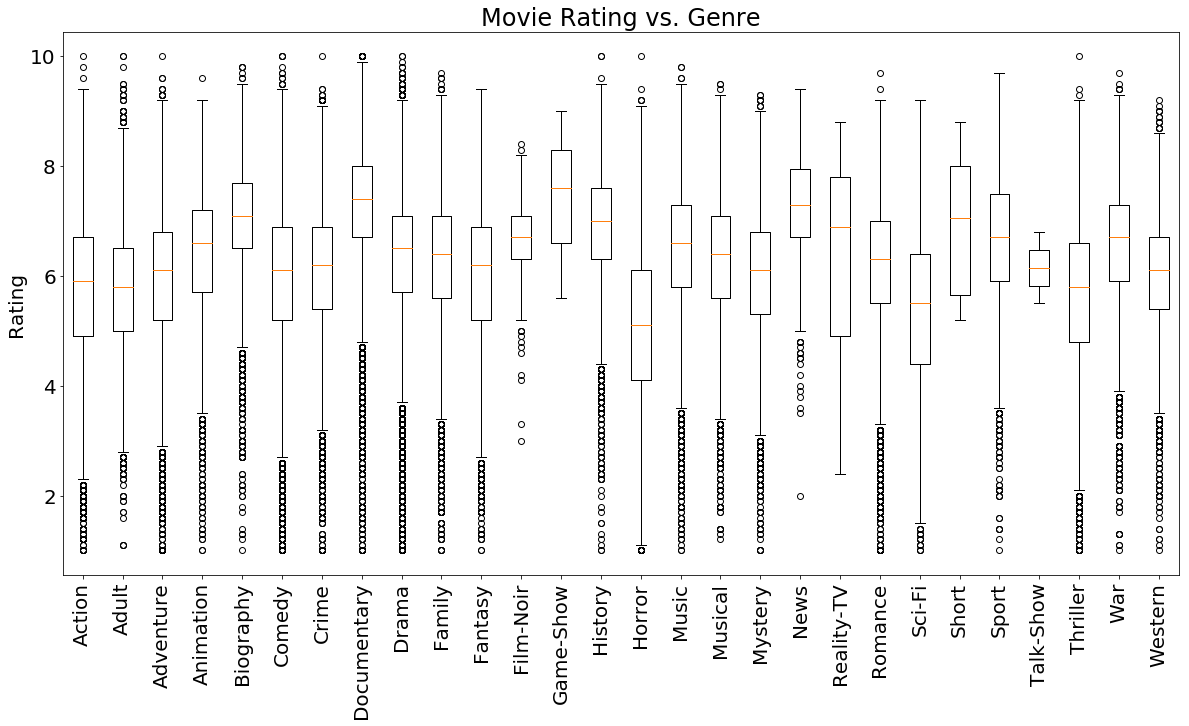

In [22]:
plt.boxplot(movie_dict.values(), labels=genres)
plt.xticks(rotation=90)
plt.ylabel("Rating")
plt.gcf().set_size_inches(20, 10)
plt.rcParams.update({'font.size': 20})
plt.title("Movie Rating vs. Genre")
plt.show()

In [19]:
tvseries_dict = dict()
for genre in genres:
    df = title_rating.loc[(title_rating[genre] == True) &
                          (title_rating["titleType"] == "tvSeries") &
                          (title_rating["averageRating"].notna()), "averageRating"]
    tvseries_dict[genre] = df

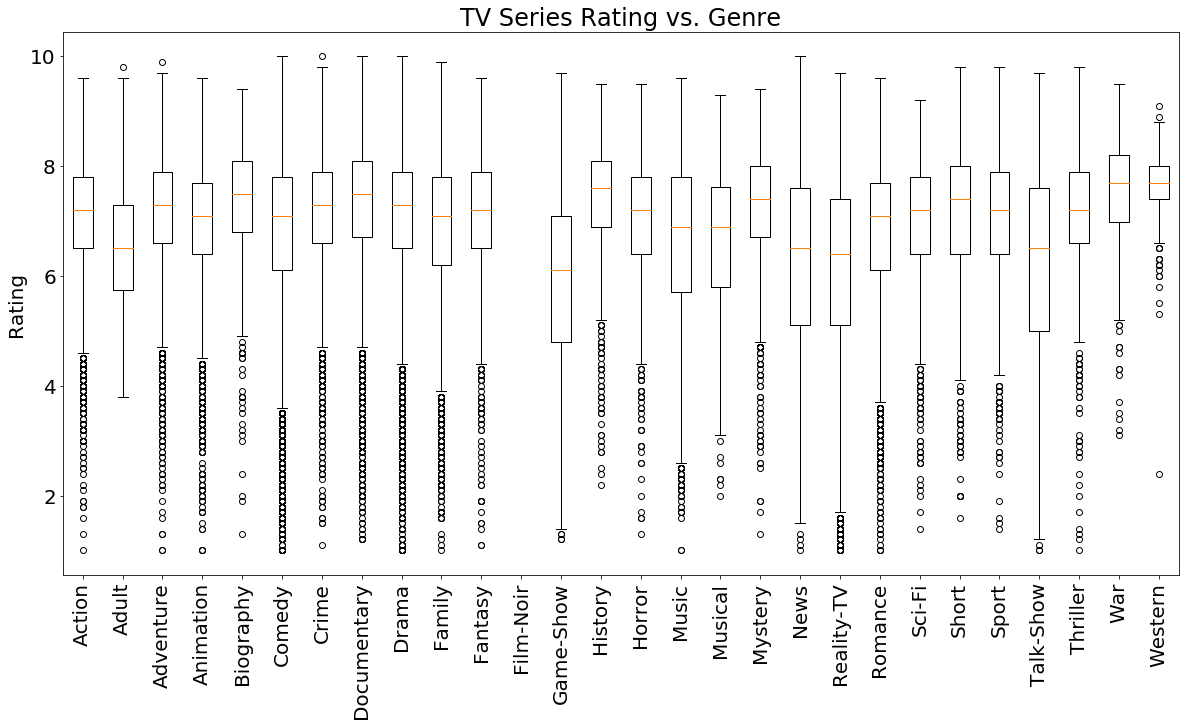

In [20]:
plt.boxplot(tvseries_dict.values(), labels=genres)
plt.xticks(rotation=90)
plt.ylabel("Rating")
plt.gcf().set_size_inches(20, 10)
plt.rcParams.update({'font.size': 20})
plt.title("TV Series Rating vs. Genre")
plt.show()

### Проведение t-тестов для выборок рейтинга по одинаковым жанрам в категориях "Фильм" и "Сериал"

In [21]:
alpha = 0.05
for genre in genres:
    df1 = movie_dict[genre]
    df2 = tvseries_dict[genre]
    
    if len(df1) == 0 or len(df2) == 0:
        continue
        
    pval = ttest_ind(df1, df2, equal_var=False).pvalue
    if pval < alpha:
        print("{0} - unequal mean ({1})".format(genre, pval))
    else:
        print("{0} - equal mean ({1})".format(genre, pval))

Action - unequal mean (0.0)
Adult - unequal mean (1.5703211487970428e-18)
Adventure - unequal mean (0.0)
Animation - unequal mean (2.50867026757604e-128)
Biography - unequal mean (1.6784140459158455e-07)
Comedy - unequal mean (0.0)
Crime - unequal mean (0.0)
Documentary - equal mean (0.8490957648436113)
Drama - unequal mean (0.0)
Family - unequal mean (8.453004588372153e-149)
Fantasy - unequal mean (2.429469230756122e-223)
Game-Show - equal mean (0.26080088695692616)
History - unequal mean (7.097042948022112e-63)
Horror - unequal mean (1.943384472946065e-259)
Music - equal mean (0.08818766180078447)
Musical - unequal mean (2.1845366340520217e-07)
Mystery - unequal mean (6.622810375837464e-280)
News - unequal mean (1.5536023454900926e-51)
Reality-TV - equal mean (0.4728667029334399)
Romance - unequal mean (4.881130731670902e-136)
Sci-Fi - unequal mean (0.0)
Short - equal mean (0.9063413323221781)
Sport - unequal mean (6.50765931734274e-23)
Talk-Show - equal mean (0.9400944114058365)
Thr